# Example Notebook to load multiple dataset from different STAC catalogs

### import packages

In [43]:
# Created by Etiënne Kras, 24-10-2024, using geo_env

import os
import pandas as pd
import pystac_client
import xarray as xr
import rioxarray as rio
import numpy as np

from copy import deepcopy
from typing import List, Dict

### Functions

In [7]:
# define function(s)

# function to put items in dataframe
def items_to_dataframe(items: List[Dict]) -> pd.DataFrame:
    """STAC items to Pandas dataframe.

    Args:
        items (List[Dict]): _description_

    Returns:
        pd.DataFrame: _description_
    """
    _items = []
    for i in items:
        _i = deepcopy(i)
        # _i['geometry'] = shape(_i['geometry'])
        # ...  # for example, drop some attributes that you're not interested in
        _items.append(_i)
    df = pd.DataFrame(pd.json_normalize(_items))
    # for field in ["properties.datetime"]:
    #     if field in df:
    #         df[field] = pd.to_datetime(df[field])
    # df = df.sort_values("properties.datetime")
    return df

### Open data from first catalog (future shorelines & SLR projections AR6)

In [2]:
# load the CoCliCo STAC catalog
catalog = pystac_client.Client.open(
    "https://storage.googleapis.com/coclico-data-public/coclico/coclico-stac-4oct/catalog.json"
)
# catalog
# see visually here: radiantearth.github.io/stac-browser/#/external/storage.googleapis.com/coclico-data-public/coclico/coclico-stac-4oct/catalog.json

# list the datasets present in the catalog, we are interested in the slp5 and slp6 sets
list(catalog.get_children())

c:\Users\kras\AppData\Local\mambaforge\envs\geo_env\lib\site-packages\pystac_client\client.py:186: NoConformsTo: Server does not advertise any conformance classes.
  warnings.warn(NoConformsTo())


[<CollectionClient id=ssl>,
 <CollectionClient id=wef>,
 <CollectionClient id=eesl>,
 <CollectionClient id=floodmaps>,
 <CollectionClient id=sc>,
 <CollectionClient id=cbca>,
 <CollectionClient id=cfr>,
 <CollectionClient id=smd>,
 <CollectionClient id=cisi>,
 <CollectionClient id=slp5>,
 <CollectionClient id=slp6>,
 <CollectionClient id=coastal-mask>,
 <CollectionClient id=overture-building-footprints>,
 <CollectionClient id=deltares-delta-dtm>,
 <CollectionClient id=gctr>,
 <CollectionClient id=pp>,
 <CollectionClient id=ceed>,
 <CollectionClient id=shorelinemonitor-shorelines>,
 <CollectionClient id=shorelinemonitor-raw-series>,
 <CollectionClient id=gcts>,
 <CollectionClient id=slp>,
 <CollectionClient id=ss_wc>,
 <CollectionClient id=twl>,
 <CollectionClient id=cet>,
 <CollectionClient id=LAU>,
 <CollectionClient id=NUTS>,
 <CollectionClient id=cfhp>,
 <CollectionClient id=CFHP_LAU_stats>]

In [8]:
%%time
# read STAC items as Pandas dataframe

# TODO: how to speed up?? 
# select one ens ..

# AR6, takes a while +/- 6 min
ar6_col = catalog.get_child("slp6")
items_ar6 = list(ar6_col.get_items()) # this is slow as we need to list all items
items_ar6_df = items_to_dataframe([i.to_dict() for i in items_ar6])

c:\Users\kras\AppData\Local\mambaforge\envs\geo_env\lib\site-packages\pystac_client\collection_client.py:145: FallbackToPystac: Falling back to pystac. This might be slow.
  root._warn_about_fallback("ITEM_SEARCH")


CPU times: total: 3min 38s
Wall time: 8min 11s


In [41]:
yr = 2100  # set year
ens = 50  # set ensemble [0-100]
var = "slr"  # set variable
ccs6 = "1-26"  # set climate change scenario for AR6

In [44]:
# filter items in datasets

# define variables
ens_list = ["5", "50", "95"]  # ensemble list to look into
yrs_list = np.arange(1970, 2200, 10)  # years to look into (step of 10 years from 1970)
key_list = ["CCS", "YRS", "ENS"]

# index AR6 dataframe on criteria
fil_idx6 = []
AR6_dict = {key: [] for key in key_list}
for idx, i in enumerate(items_ar6_df.id):
    enss = str(i).split("/")[1].split("ens")[-1]  # ensemble
    yrs = int(str(i).split("/")[2][0:4])  # yrs
    ccs = str(i).split("/")[0].split("=")[-1] # ccs
    if enss in [str(float(x)) for x in ens_list] and yrs in yrs_list:  # constraining read ensembles and years
        AR6_dict["CCS"].append(ccs)
        AR6_dict["YRS"].append(yrs)
        AR6_dict["ENS"].append(enss)
        fil_idx6.append(idx)

# filter AR6 dataframe and STAC items on index
items_df_fil6 = items_ar6_df.filter(items = fil_idx6, axis=0)
items_fil6 = [items_ar6[i] for i in fil_idx6]

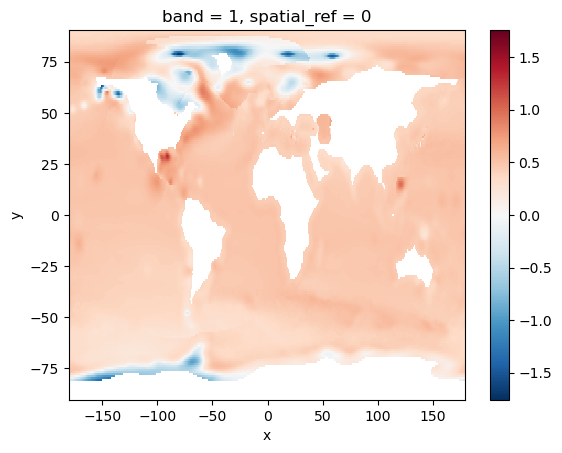

In [49]:
# get data

# get AR6 collection and item href
for i in items_fil6:
    if i.id == r"ssp=%s/%s_ens%s/%s.tif" % (ccs6, var, float(ens), yr):
        ar6_item_href = i.assets["data"].href

ar6_item = rio.open_rasterio(ar6_item_href, masked=True)
ar6_item_corr = ar6_item / 1000
ar6_item_corr.plot()

# cbar limits
# vmin = max(
#     min(np.nanmin(ar5_item), np.nanmin(ar6_item_corr)), -0.2
# )  # bound to -0.2 if smaller than this value
# vmax = max(np.nanmax(ar5_item), np.nanmax(ar6_item_corr))

# colormap
#cwd = pathlib.Path().resolve().parent
#slev_divl = np.loadtxt(str(pathlib.Path.joinpath(cwd, r"src/coclico/colormaps/slev_div.txt")))
#slev_div = mcolors.LinearSegmentedColormap.from_list('slev_div', slev_divl/255)

In [26]:
sc_col = catalog.get_child("sc")
href_sc = sc_col.assets["data"].href

# Printing the dataset object shows the storm surge level consists of three dimensions.
# Every storm surge level is associated with a certain station, scenario and revisting period.
ds = xr.open_zarr(href_sc)
ds

<xarray.Dataset>
Dimensions:    (nensemble: 7, stations: 518005, nscenarios: 2, time: 2)
Coordinates:
    ensemble   (nensemble) |S3 dask.array<chunksize=(7,), meta=np.ndarray>
    lat        (stations) float64 dask.array<chunksize=(64751,), meta=np.ndarray>
    lon        (stations) float64 dask.array<chunksize=(64751,), meta=np.ndarray>
    scenarios  (nscenarios) |S5 dask.array<chunksize=(2,), meta=np.ndarray>
  * time       (time) int32 2050 2100
Dimensions without coordinates: nensemble, stations, nscenarios
Data variables:
    sc         (nscenarios, stations, time, nensemble) float64 dask.array<chunksize=(1, 64751, 1, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.8
    crs:          4326
    description:  Projections of global shoreline change in view of climate c...
    source:       The procedure to produce the dataset and the findings are d...
    title:        Global shoreline change projections for the year 2050 under...

In [ ]:
# TODO: plot on map

### Open data from second catalog (world pop & subsidence)

In [50]:
# load the GCA SOTC STAC catalog
catalog2 = pystac_client.Client.open(
    "https://storage.googleapis.com/dgds-data-public/gca/SOTC/gca-sotc/catalog.json"
)
# catalog
# see visually here: https://radiantearth.github.io/stac-browser/#/external/storage.googleapis.com/dgds-data-public/gca/SOTC/gca-sotc/catalog.json

# list the datasets present in the catalog, we are interested in the slp5 and slp6 sets
list(catalog2.get_children())

c:\Users\kras\AppData\Local\mambaforge\envs\geo_env\lib\site-packages\pystac_client\client.py:186: NoConformsTo: Server does not advertise any conformance classes.
  warnings.warn(NoConformsTo())


[<CollectionClient id=shore_mon_fut>,
 <CollectionClient id=sed_class>,
 <CollectionClient id=shore_mon>,
 <CollectionClient id=shore_mon_hr>,
 <CollectionClient id=shore_mon_drivers>,
 <CollectionClient id=esl_gwl>,
 <CollectionClient id=sub_threat>,
 <CollectionClient id=Exp_world_pop>,
 <CollectionClient id=Exp_world_pop_parquet>,
 <CollectionClient id=Haz-ESL>,
 <CollectionClient id=Vul-Inf_Mort>,
 <CollectionClient id=Exp-NS_Slopes>,
 <CollectionClient id=Vul_MYS>,
 <CollectionClient id=Vul_RS>,
 <CollectionClient id=Vul-GDP_Cap>,
 <CollectionClient id=Haz-Land_Sub_2010_COGs>,
 <CollectionClient id=Haz-Land_Sub_2040_COGs>,
 <CollectionClient id=Vul-Roads_Density_COGs>,
 <CollectionClient id=Exp-Delta_DEM_COGs>,
 <CollectionClient id=Haz-ERA5_93-23>,
 <CollectionClient id=Vul_World_Protected_Areas>,
 <CollectionClient id=Haz-MRI-ESM2-0_Hind_93-14>,
 <CollectionClient id=Haz-MPI-ESM1-2-LR_Hind_93-14>,
 <CollectionClient id=Haz-KIOST-ESM_Hind_93-14>,
 <CollectionClient id=Haz-IPSL-CM

In [ ]:
%%time
# read STAC items as Pandas dataframe

# TODO: how to speed up?? 
# select one ens ..

# AR6, takes a while +/- 6 min
sub_col = catalog2.get_child("Haz-Land_Sub_2040_COGs")
items_sub = list(sub_col.get_items()) # this is slow as we need to list all items
items_sub_df = items_to_dataframe([i.to_dict() for i in items_sub])

In [ ]:
# TODO: plot on map

In [53]:
# parquet file

pop_col = catalog2.get_child("Exp_world_pop_parquet")

# TODO: open parquet file
href_pop = pop_col.assets["data"].href

In [54]:
pd.read_parquet('example_pa.parquet', engine='pyarrow')

'gs://dgds-data-public/gca/SOTC/Exp_world_pop.parquet/*.parquet'

In [ ]:
# TODO: plot on map